In [45]:
import tensorflow as tf
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns

file_path = "time_series_data/TSLA_time_series.csv"

df = pd.read_csv(file_path)
df

,datetime,open,high,low,close,volume,previous open,open-change,open-trend,percent_b,macd,macd_signal,macd_hist,adx,ema,rsi
0,2023-12-05 10:40:00,243.69,243.80,243.40,243.74,306647,0.00,0.00,1,0.82,0.66,0.66,0.00,39.00,243.43,68.69
1,2023-12-05 10:41:00,243.75,243.99,243.34,243.52,459996,0.00,0.00,1,0.72,0.63,0.65,-0.02,38.92,243.45,64.15
2,2023-12-05 10:42:00,243.53,243.92,243.49,243.71,333910,243.69,-0.16,0,0.76,0.62,0.65,-0.03,38.85,243.50,66.23
3,2023-12-05 10:43:00,243.74,244.33,243.71,244.21,800472,243.75,-0.01,0,0.89,0.64,0.64,-0.01,39.42,243.64,70.99
4,2023-12-05 10:44:00,244.20,244.73,244.14,244.65,725932,243.53,0.67,1,0.95,0.68,0.65,0.03,40.44,243.85,74.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2023-12-21 15:55:00,254.49,254.60,254.42,254.60,184960,254.66,-0.17,0,0.81,0.11,0.09,0.02,13.26,254.50,58.96
4996,2023-12-21 15:56:00,254.60,254.71,254.50,254.68,240090,254.59,0.01,1,0.87,0.12,0.10,0.02,12.48,254.53,61.36
4997,2023-12-21 15:57:00,254.68,254.69,254.52,254.55,213734,254.49,0.19,1,0.70,0.11,0.10,0.01,11.75,254.54,55.97
4998,2023-12-21 15:58:00,254.53,254.62,254.43,254.62,401556,254.60,-0.07,0,0.76,0.11,0.10,0.01,11.56,254.55,58.10


In [32]:
df.index = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.drop(["datetime"], axis=1, inplace=True)
df['day_of_week'] = df.index.day_of_week
df['hour'] = df.index.hour
target_column = df['open-trend']
test_size = 0.2
forward_lead = 2
df['target'] = target_column.shift(-1)
df = df.iloc[forward_lead:]
df

,open,high,low,close,volume,open-trend,open-change,previous open,percent_b,macd,macd_signal,macd_hist,adx,ema,rsi,day_of_week,hour,target
datetime,,,,,,,,,,,,,,,,,,
2023-12-05 10:42:00,243.53,243.92,243.49,243.71,333910,0,-0.16,243.69,0.76,0.62,0.65,-0.03,38.85,243.50,66.23,1,10,0.0
2023-12-05 10:43:00,243.74,244.33,243.71,244.21,800472,0,-0.01,243.75,0.89,0.64,0.64,-0.01,39.42,243.64,70.99,1,10,1.0
2023-12-05 10:44:00,244.20,244.73,244.14,244.65,725932,1,0.67,243.53,0.95,0.68,0.65,0.03,40.44,243.85,74.41,1,10,1.0
2023-12-05 10:45:00,244.67,245.27,244.65,245.15,1041878,1,0.93,243.74,1.02,0.75,0.67,0.08,41.90,244.11,77.63,1,10,1.0
2023-12-05 10:46:00,245.16,245.50,245.02,245.12,827825,1,0.96,244.20,0.95,0.79,0.69,0.09,43.45,244.31,76.90,1,10,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21 15:55:00,254.49,254.60,254.42,254.60,184960,0,-0.17,254.66,0.81,0.11,0.09,0.02,13.26,254.50,58.96,3,15,1.0
2023-12-21 15:56:00,254.60,254.71,254.50,254.68,240090,1,0.01,254.59,0.87,0.12,0.10,0.02,12.48,254.53,61.36,3,15,1.0
2023-12-21 15:57:00,254.68,254.69,254.52,254.55,213734,1,0.19,254.49,0.70,0.11,0.10,0.01,11.75,254.54,55.97,3,15,0.0


In [33]:
index = 1290

for i in range(index, index + forward_lead):
    current_open_price = df.iloc[i + forward_lead]["open"]
    current_open_trend = df.iloc[i + forward_lead]["open-trend"]
    current_open_change = df.iloc[i + forward_lead]["open-change"]
    old_open_price = df.iloc[i]["open"]
    trend_from_last_entry = df.iloc[i + forward_lead -1]["target"]
    print(f"Current: {current_open_price}, Old: {old_open_price}, Trend: {current_open_trend}, Change: {current_open_change}, last trend: {trend_from_last_entry}")


Current: 241.54, Old: 241.35, Trend: 1.0, Change: 0.19, last trend: 1.0
Current: 241.43, Old: 241.42, Trend: 1.0, Change: 0.01, last trend: 1.0


In [34]:
def get_recent_time_series_batch() -> tuple:
    seq_length: int = 10
    target_column_name: str = "target"
    time_series_batch = []
    time_series_target = []

    for row in range(len(df) - seq_length):
        time_series_batch.append(df.iloc[row:row + seq_length].values)
        time_series_target.append(df[target_column_name].iloc[row + seq_length - 1])

    time_series_batch = np.array(time_series_batch)
    time_series_target= np.array(time_series_target)
    return time_series_batch, time_series_target

X, y = get_recent_time_series_batch()

"""
X is a list with contains (len(df) - seq_length) entries. The first entry is a list of the first seq_length rows of df. X[index][-1] gives you the (index + seq_length)-th row of df.
y is a list that contains (len(df) - seq_length) entries. The first entry is the "target" column of the seq_length row. X[index][-1][-1] and y[index] are the same "target" value.
If df has 5000 entries, X.shape y.shape will give you: ((4980, 10, 25), (4980,))
"""
X.shape, y.shape

((4988, 10, 18), (4988,))

In [35]:
# Split the data into training and temporary sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Further split the temporary set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=test_size, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Print the shapes of the sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (3192, 10, 18) (3192,)
Validation set shape: (798, 10, 18) (798,)
Test set shape: (998, 10, 18) (998,)


In [41]:
from keras.src.layers import LSTM, Dropout, Dense
from keras import Sequential

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/30
200/200 [==============================] - 4s 7ms/step - loss: 0.6921 - accuracy: 0.5379 - val_loss: 0.6755 - val_accuracy: 0.6516
Epoch 2/30
200/200 [==============================] - 1s 5ms/step - loss: 0.6671 - accuracy: 0.6338 - val_loss: 0.6511 - val_accuracy: 0.7419
Epoch 3/30
200/200 [==============================] - 1s 5ms/step - loss: 0.6395 - accuracy: 0.7121 - val_loss: 0.6159 - val_accuracy: 0.8033
Epoch 4/30
200/200 [==============================] - 1s 5ms/step - loss: 0.6015 - accuracy: 0.7757 - val_loss: 0.5776 - val_accuracy: 0.8396
Epoch 5/30
200/200 [==============================] - 1s 5ms/step - loss: 0.5665 - accuracy: 0.8095 - val_loss: 0.5340 - val_accuracy: 0.8659
Epoch 6/30
200/200 [==============================] - 1s 5ms/step - loss: 0.5234 - accuracy: 0.8493 - val_loss: 0.4901 - val_accuracy: 0.9411
Epoch 7/30
200/200 [==============================] - 1s 5ms/step - loss: 0.4821 - accuracy: 0.8929 - val_loss: 0.4483 - val_accuracy: 0.9962
Epoch 

32/32 [==============================] - 0s 2ms/step - loss: 0.0383 - accuracy: 1.0000
Test Loss: 0.0383, Test Accuracy: 100.00%


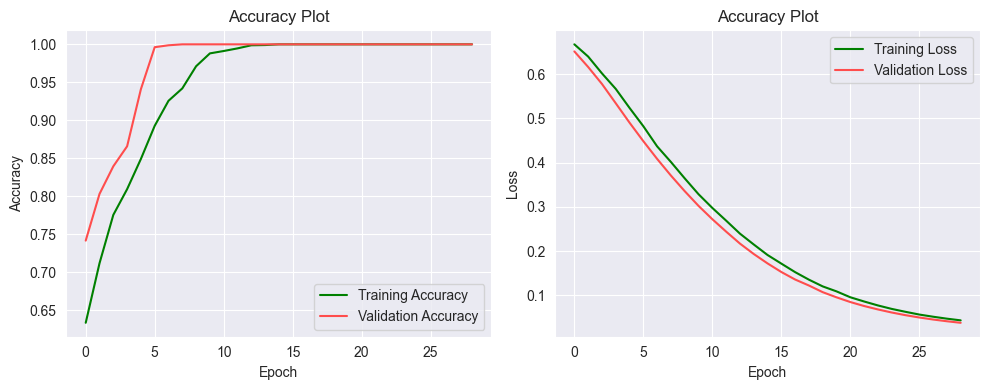

In [42]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(history.history['accuracy'][1:], label='Training Accuracy', color="green")
ax1.plot(history.history['val_accuracy'][1:], label='Validation Accuracy', color="#ff4d4d")

ax1.set_title('Accuracy Plot')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'][1:], label='Training Loss', color="green")
ax2.plot(history.history['val_loss'][1:], label='Validation Loss', color="#ff4d4d")

ax2.set_title('Accuracy Plot')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [43]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

y_actual = y_test
results_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred.flatten(), 'Predicted_Prob': y_pred_prob.flatten()})
results_df

32/32 [==============================] - 0s 2ms/step


,Actual,Predicted,Predicted_Prob
0,1.0,1,0.947646
1,0.0,0,0.022678
2,1.0,1,0.987654
3,1.0,1,0.965137
4,0.0,0,0.039808
...,...,...,...
993,0.0,0,0.040263
994,0.0,0,0.020275
995,1.0,1,0.984509
996,0.0,0,0.016872


In [39]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC: 1.0000


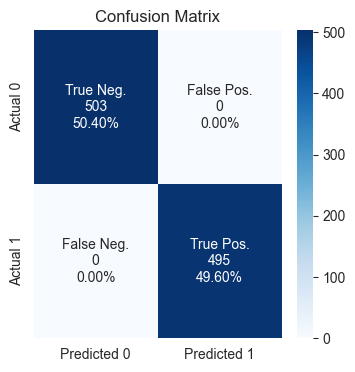

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(4, 4))

group_names = ["True Neg.","False Pos.","False Neg.","True Pos."]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', cbar=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()